#### By: Peyman Shahidi
#### Created: Oct 9, 2025
#### Last Edit: Oct 16, 2025

<br>

In [227]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [228]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots"

In [229]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [230]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Remove apostrophes for consistency
ONET = ONET.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,FT_Daily,FT_Hourly or more,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organizations financia...,Core,5,9.62,124.47,46.67,5.26,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,25.27,4.81,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,35.11,3.73,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.47,6.38,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,7.87,0.65,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [231]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")
# Drop the first column
gpts_full_labels = gpts_full_labels.drop(gpts_full_labels.columns[:1], axis=1)

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")


gpts_full_labels.head(5)

Number of rows in GPTs full labels dataset: 19,265


,O*NET-SOC Code,Task ID,Task Title,Task Type,Occupation Title,human_exposure_agg,gpt4_exposure,gpt4_exposure_alt_rubric,gpt_3_relevant,gpt4_automation,alpha,beta,gamma,automation,human_labels
0,11-1011.00,8823,Direct or coordinate an organizations financia...,Core,Chief Executives,E0,E2,E2,False,T2,0.00,0.50,1.00,0.50,E0
1,11-1011.00,8831,Appoint department heads or managers and assig...,Core,Chief Executives,E0,E0,E0,False,T1,0.00,0.00,0.00,0.25,E0
2,11-1011.00,8825,Analyze operations to evaluate performance of ...,Core,Chief Executives,E2,E2,E2,False,T2,0.00,0.50,1.00,0.50,E2
3,11-1011.00,8826,"Direct, plan, or implement policies, objective...",Core,Chief Executives,E0,E2,E0,False,T1,0.00,0.50,1.00,0.25,E0
4,11-1011.00,8827,"Prepare budgets for approval, including those ...",Core,Chief Executives,E2,E2,E2,False,T2,0.00,0.50,1.00,0.50,E2


In [ ]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 0


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,FT_Daily,FT_Hourly or more,...,human_exposure_agg,gpt4_exposure,gpt4_exposure_alt_rubric,gpt_3_relevant,gpt4_automation,alpha,beta,gamma,automation,human_labels
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organizations financia...,Core,5,9.62,124.47,46.67,5.26,...,E0,E2,E2,False,T2,0.00,0.50,1.00,0.50,E0
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,25.27,4.81,...,E0,E0,E0,False,T1,0.00,0.00,0.00,0.25,E0
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,35.11,3.73,...,E2,E2,E2,False,T2,0.00,0.50,1.00,0.50,E2
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.47,6.38,...,E0,E2,E0,False,T1,0.00,0.50,1.00,0.25,E0
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,7.87,0.65,...,E2,E2,E2,False,T2,0.00,0.50,1.00,0.50,E2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17948,53-7121.00,"Tank Car, Truck, and Ship Loaders",12806,"Test vessels for leaks, damage, and defects, a...",Supplemental,2,4.96,29.10,44.97,19.77,...,E0,E0,E0,False,T0,0.00,0.00,0.00,0.00,E0
17949,53-7121.00,"Tank Car, Truck, and Ship Loaders",12807,Unload cars containing liquids by connecting h...,Supplemental,2,2.11,29.10,27.65,8.34,...,E0,E0,E0,False,T0,0.00,0.00,0.00,0.00,E0
17950,53-7121.00,"Tank Car, Truck, and Ship Loaders",12808,Copy and attach load specifications to loaded ...,Supplemental,2,5.04,29.10,34.11,18.45,...,E2,E0,E0,False,T0,0.00,0.00,0.00,0.00,E2
17951,53-7121.00,"Tank Car, Truck, and Ship Loaders",12809,Start pumps and adjust valves or cables to reg...,Core,2,6.93,29.10,38.33,25.23,...,E0,E0,E0,False,T0,0.00,0.00,0.00,0.00,E0


## Create Measures:

E0 --> Manual
E1 --> Automated
E2 --> Augmented

1. Calculate share of E0, E1, E2, and E1+E2 within each major, minor, broad, detailed, occupation.
3. Add number of tasks within each level.

In [233]:
# Create automation measures directly in ONET dataset
ONET['E0_Manual'] = (ONET['gpt4_exposure'] == 'E0').astype(int)
ONET['E1_Automated'] = (ONET['gpt4_exposure'] == 'E1').astype(int)  
ONET['E2_Augmented'] = (ONET['gpt4_exposure'] == 'E2').astype(int)
ONET['E1_E2_Combined'] = ((ONET['gpt4_exposure'] == 'E1') | (ONET['gpt4_exposure'] == 'E2')).astype(int)

print("Automation measures created successfully!")
print(f"Total tasks: {len(ONET):,}")
print(f"E0 (Manual): {ONET['E0_Manual'].sum():,}")
print(f"E1 (Automated): {ONET['E1_Automated'].sum():,}")
print(f"E2 (Augmented): {ONET['E2_Augmented'].sum():,}")
print(f"E1+E2 (Combined): {ONET['E1_E2_Combined'].sum():,}")

# Verify totals add up
print(f"\nVerification: {ONET['E0_Manual'].sum() + ONET['E1_Automated'].sum() + ONET['E2_Augmented'].sum()} = {len(ONET)}")

Automation measures created successfully!
Total tasks: 17,953
E0 (Manual): 8,178
E1 (Automated): 2,433
E2 (Augmented): 7,342
E1+E2 (Combined): 9,775

Verification: 17953 = 17953


In [234]:
# Function to calculate automation shares at different levels
def calculate_automation_shares(df, group_cols, level_name):
    """
    Calculate automation shares and task counts for a given grouping level.
    
    Parameters:
    df: DataFrame with automation measures
    group_cols: List of columns to group by
    level_name: String name for the level (for reporting)
    
    Returns:
    DataFrame with shares and counts
    """
    
    # Group and calculate shares
    grouped = df.groupby(group_cols).agg({
        'E0_Manual': ['sum', 'mean'],
        'E1_Automated': ['sum', 'mean'], 
        'E2_Augmented': ['sum', 'mean'],
        'E1_E2_Combined': ['sum', 'mean'],
        'Task ID': 'count'  # Count of tasks
    }).round(4)
    
    # Flatten column names
    grouped.columns = [f'{col[0]}_{col[1]}' for col in grouped.columns]
    
    # Rename count column
    grouped = grouped.rename(columns={'Task ID_count': 'n_tasks'})
    
    # Add percentage columns (mean * 100)
    grouped['E0_share_pct'] = grouped['E0_Manual_mean'] * 100
    grouped['E1_share_pct'] = grouped['E1_Automated_mean'] * 100
    grouped['E2_share_pct'] = grouped['E2_Augmented_mean'] * 100
    grouped['E1_E2_share_pct'] = grouped['E1_E2_Combined_mean'] * 100
    
    # Reorder columns for clarity
    cols_order = [
        'n_tasks',
        'E0_Manual_sum', 'E0_share_pct',
        'E1_Automated_sum', 'E1_share_pct', 
        'E2_Augmented_sum', 'E2_share_pct',
        'E1_E2_Combined_sum', 'E1_E2_share_pct'
    ]
    
    result = grouped[cols_order].copy()
    
    # Reset index to make group columns regular columns
    result = result.reset_index()
    
    print(f"\n=== {level_name} Level Analysis ===")
    print(f"Number of {level_name.lower()} groups: {len(result):,}")
    print(f"Total tasks across all groups: {result['n_tasks'].sum():,}")
    
    return result

print("Function defined successfully!")

Function defined successfully!


In [235]:
# Calculate automation shares at different occupation hierarchy levels

# 1. Major Group Level
major_results = calculate_automation_shares(
    ONET, 
    ['Major_Group_Code', 'Major_Group_Title'], 
    'Major Group'
)

# 2. Minor Group Level  
minor_results = calculate_automation_shares(
    ONET,
    # ['Major_Group_Code', 'Major_Group_Title', 'Minor_Group_Code', 'Minor_Group_Title'],
    ['Minor_Group_Code', 'Minor_Group_Title'],
    'Minor Group'
)

# 3. Broad Occupation Level
broad_results = calculate_automation_shares(
    ONET,
    # ['Major_Group_Code', 'Major_Group_Title', 'Minor_Group_Code', 'Minor_Group_Title', 
    #  'Broad_Occupation_Code', 'Broad_Occupation_Title'],
    ['Broad_Occupation_Code', 'Broad_Occupation_Title'],
    'Broad Occupation'
)

# 4. Detailed Occupation Level
detailed_results = calculate_automation_shares(
    ONET,
    # ['Major_Group_Code', 'Major_Group_Title', 'Minor_Group_Code', 'Minor_Group_Title',
    #  'Broad_Occupation_Code', 'Broad_Occupation_Title', 'Detailed_Occupation_Code', 'Detailed_Occupation_Title'],
    ['Detailed_Occupation_Code', 'Detailed_Occupation_Title'],
    'Detailed Occupation'
)

# 5. Individual Occupation Level (O*NET-SOC Code)
occupation_results = calculate_automation_shares(
    ONET,
    ['O*NET-SOC Code', 'Occupation Title'],
    'Individual Occupation'
)


=== Major Group Level Analysis ===
Number of major group groups: 22
Total tasks across all groups: 17,953

=== Minor Group Level Analysis ===
Number of minor group groups: 95
Total tasks across all groups: 14,602

=== Broad Occupation Level Analysis ===
Number of broad occupation groups: 430
Total tasks across all groups: 17,787

=== Detailed Occupation Level Analysis ===
Number of detailed occupation groups: 759
Total tasks across all groups: 17,953

=== Individual Occupation Level Analysis ===
Number of individual occupation groups: 873
Total tasks across all groups: 17,953


In [236]:
# Save all datasets to CSV files
datasets = {
    'automation_shares_major_group': major_results,
    'automation_shares_minor_group': minor_results, 
    'automation_shares_broad_occupation': broad_results,
    'automation_shares_detailed_occupation': detailed_results,
    'automation_shares_individual_occupation': occupation_results
}

print("Saving datasets to CSV files...")
print("="*50)

# Create output directory if it doesn't exist
output_dir = f'{output_data_path}/my_measures'
os.makedirs(output_dir, exist_ok=True)
for name, dataset in datasets.items():
    filename = f"{output_dir}/{name}.csv"
    dataset.to_csv(filename, index=False)
    print(f"✓ Saved {name}: {len(dataset):,} rows → {filename}")

print(f"\\nAll files saved to: {output_dir}/")
print("DATASET CREATION COMPLETED SUCCESSFULLY!")

Saving datasets to CSV files...
✓ Saved automation_shares_major_group: 22 rows → ../data/computed_objects/my_measures/automation_shares_major_group.csv
✓ Saved automation_shares_minor_group: 95 rows → ../data/computed_objects/my_measures/automation_shares_minor_group.csv
✓ Saved automation_shares_broad_occupation: 430 rows → ../data/computed_objects/my_measures/automation_shares_broad_occupation.csv
✓ Saved automation_shares_detailed_occupation: 759 rows → ../data/computed_objects/my_measures/automation_shares_detailed_occupation.csv
✓ Saved automation_shares_individual_occupation: 873 rows → ../data/computed_objects/my_measures/automation_shares_individual_occupation.csv
\nAll files saved to: ../data/computed_objects/my_measures/
DATASET CREATION COMPLETED SUCCESSFULLY!


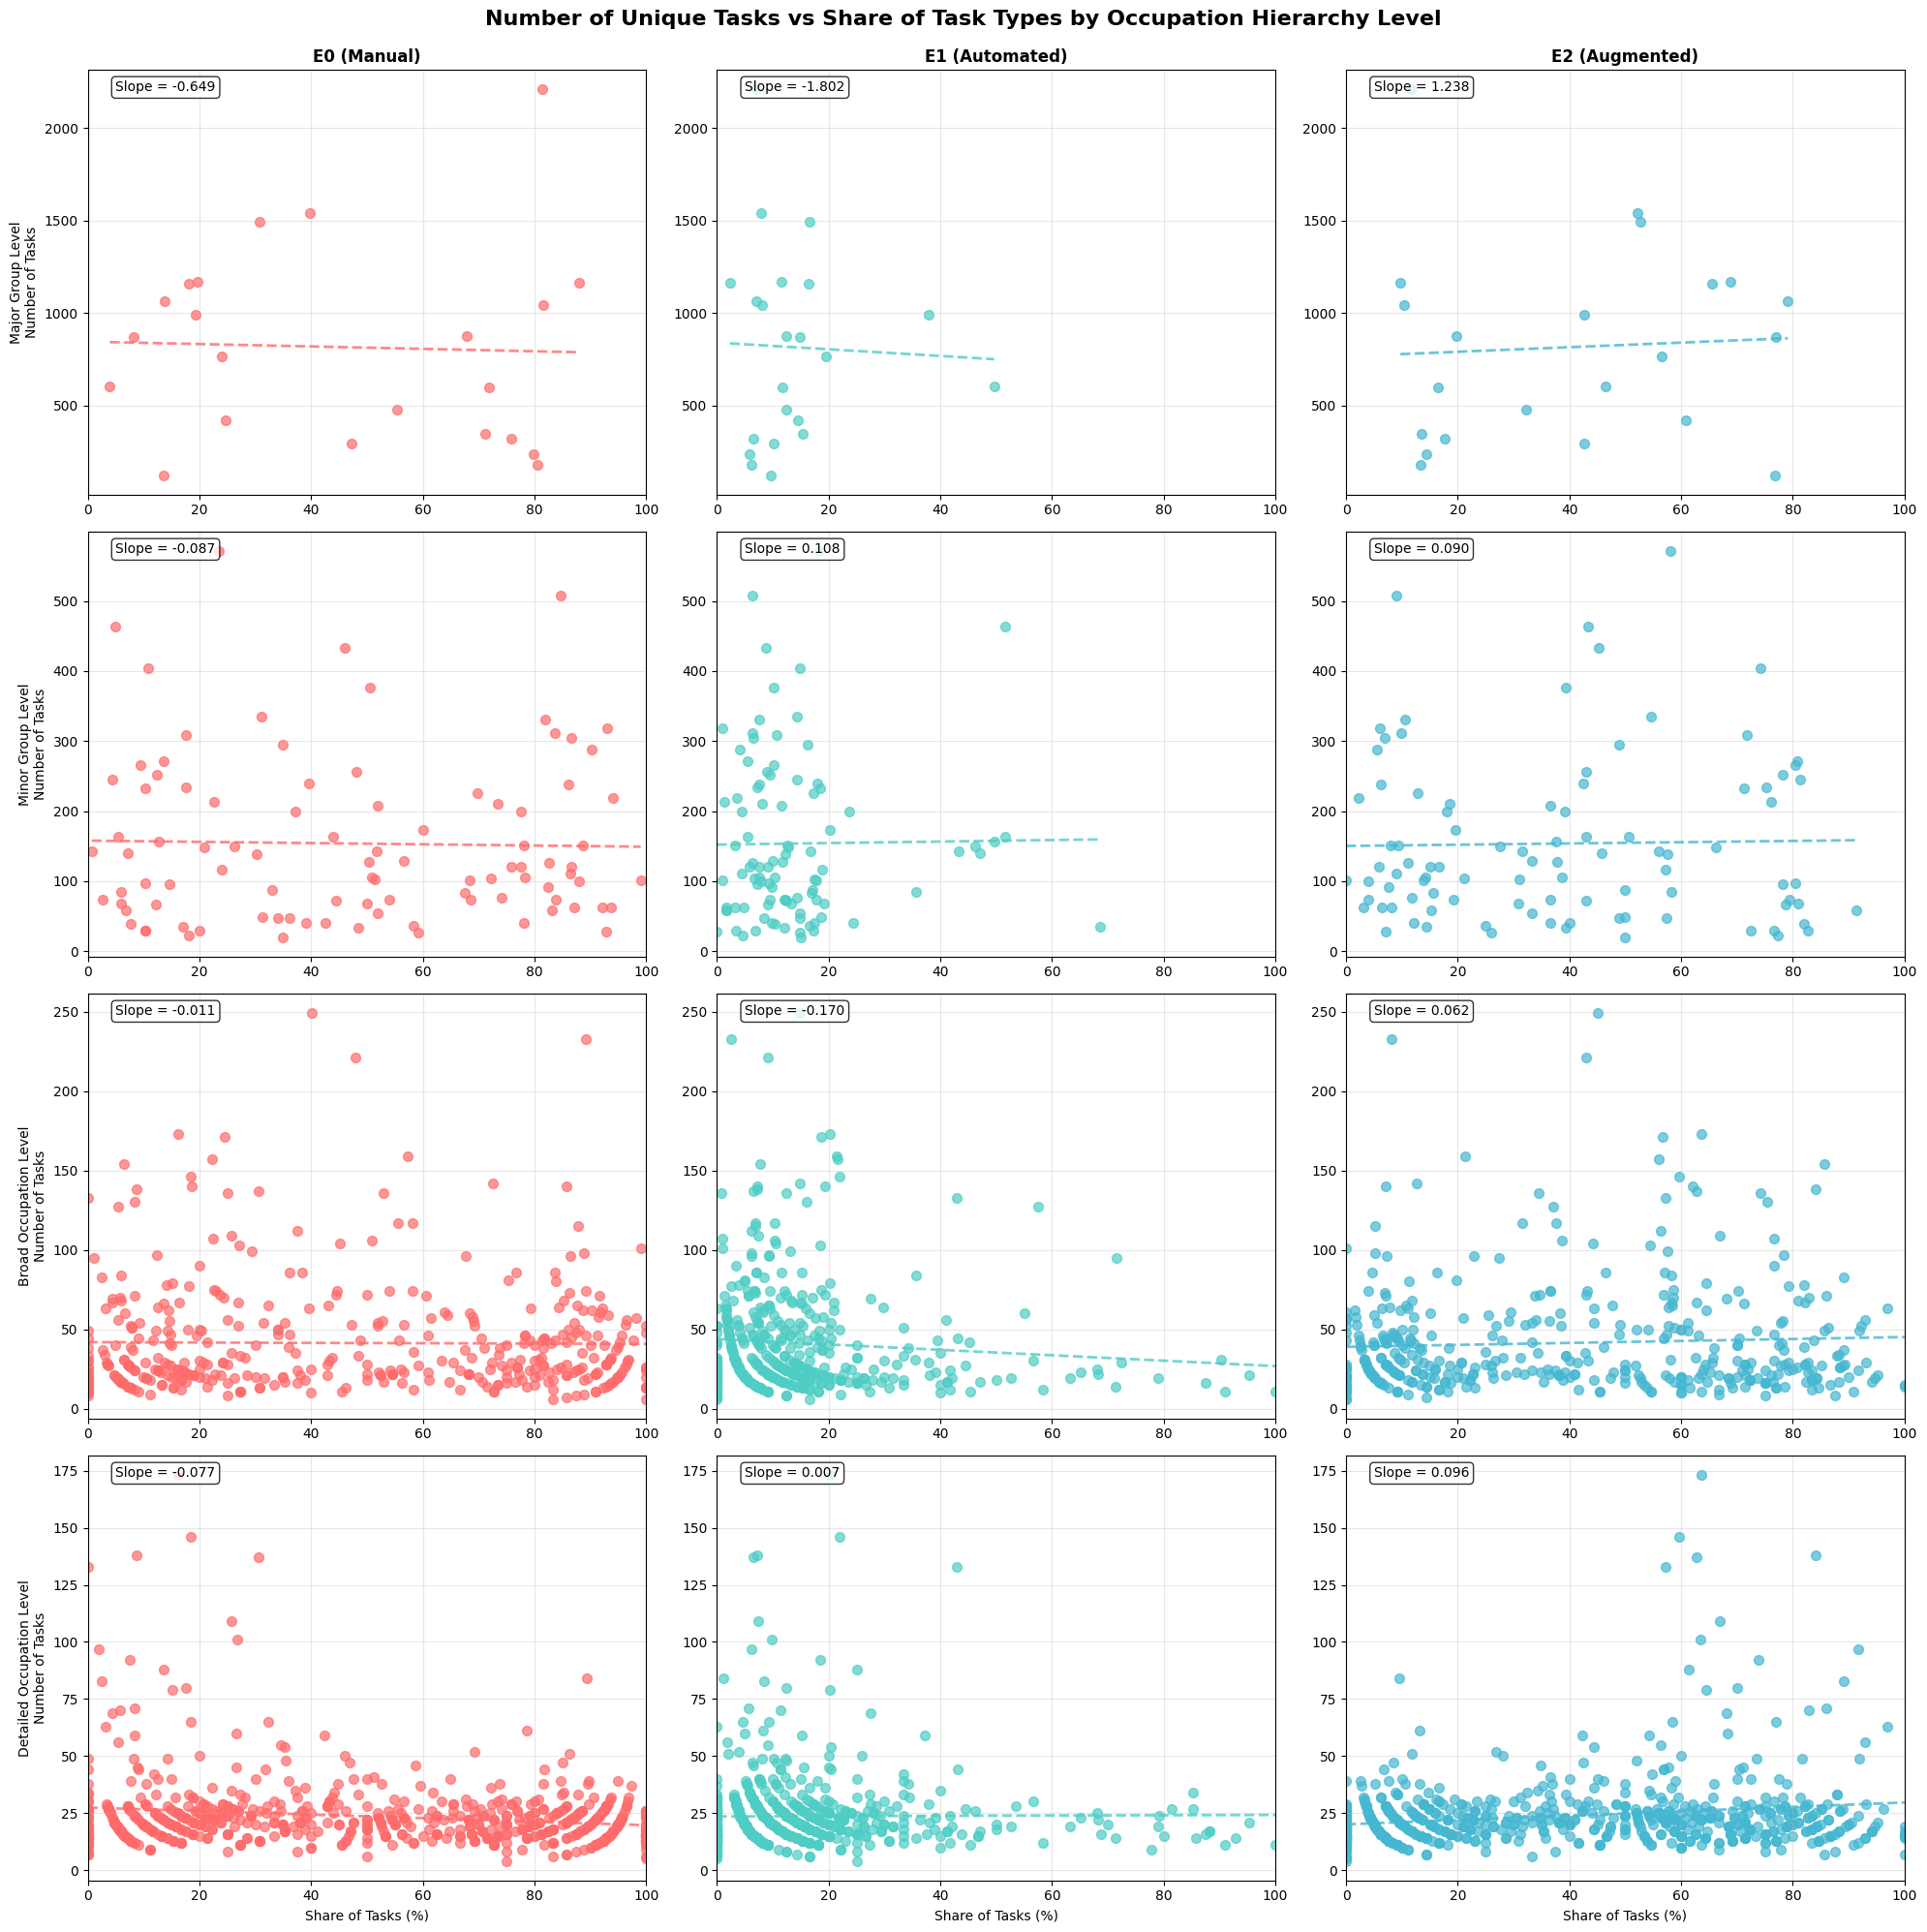

First 5x3 scatter plot (tasks) created successfully!
Plot saved to: ../writeup/plots/tasks_vs_task_shares_scatter.png


In [237]:
# Create 5x3 figure: Number of unique tasks vs share of E0, E1, E2 tasks
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Prepare data for plotting (excluding Individual Occupation Level)
datasets_for_plot = [
    (major_results, 'Major Group Level'),
    (minor_results, 'Minor Group Level'), 
    (broad_results, 'Broad Occupation Level'),
    (detailed_results, 'Detailed Occupation Level')
]

# Create figure with 4x3 subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
fig.suptitle('Number of Unique Tasks vs Share of Task Types by Occupation Hierarchy Level', 
             fontsize=16, fontweight='bold', y=0.995)

# Colors and labels
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Red for E0, Teal for E1, Blue for E2
task_types = [('E0_share_pct', 'E0 (Manual)'), ('E1_share_pct', 'E1 (Automated)'), ('E2_share_pct', 'E2 (Augmented)')]

for i, (data, level_name) in enumerate(datasets_for_plot):
    for j, (share_col, task_label) in enumerate(task_types):
        ax = axes[i, j]
        
        # Get data for this plot
        x = data[share_col].values
        y = data['n_tasks'].values
        
        # Create scatter plot
        ax.scatter(x, y, color=colors[j], alpha=0.7, s=50)
        
        # Fit and plot regression line
        if len(x) > 1:  # Need at least 2 points for regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            line_x = np.linspace(x.min(), x.max(), 100)
            line_y = slope * line_x + intercept
            ax.plot(line_x, line_y, color=colors[j], linestyle='--', linewidth=2, alpha=0.8)
            
            # Add slope value
            ax.text(0.05, 0.95, f'Slope = {slope:.3f}', 
                   transform=ax.transAxes, fontsize=10, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Customize plot
        if i == 0:  # Add title only to top row
            ax.set_title(f'{task_label}', fontsize=12, fontweight='bold')
        
        if i == 3:  # Add x-label only to bottom row
            ax.set_xlabel('Share of Tasks (%)')
        
        if j == 0:  # Add y-label only to leftmost column
            ax.set_ylabel(f'{level_name}\nNumber of Tasks')
        
        # Add grid
        ax.grid(True, alpha=0.3)
        
        # Set x-axis limits
        ax.set_xlim(0, 100)

plt.tight_layout()
plt.savefig(f'{output_plot_path}/tasks_vs_task_shares_scatter.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("First 5x3 scatter plot (tasks) created successfully!")
print(f"Plot saved to: {output_plot_path}/tasks_vs_task_shares_scatter.png")

In [238]:
# First, we need to calculate the number of unique occupations for each group
# We'll need to go back to the original ONET data and count unique occupations per group

def calculate_automation_shares_with_occupations(df, group_cols, level_name):
    """
    Calculate automation shares, task counts, and unique occupation counts for a given grouping level.
    """
    
    # Group and calculate shares and counts
    grouped = df.groupby(group_cols).agg({
        'E0_Manual': ['sum', 'mean'],
        'E1_Automated': ['sum', 'mean'], 
        'E2_Augmented': ['sum', 'mean'],
        'E1_E2_Combined': ['sum', 'mean'],
        'Task ID': 'count',  # Count of tasks
        'O*NET-SOC Code': 'nunique'  # Count of unique occupations
    }).round(4)
    
    # Flatten column names
    grouped.columns = [f'{col[0]}_{col[1]}' for col in grouped.columns]
    
    # Rename count columns
    grouped = grouped.rename(columns={
        'Task ID_count': 'n_tasks',
        'O*NET-SOC Code_nunique': 'n_occupations'
    })
    
    # Add percentage columns (mean * 100)
    grouped['E0_share_pct'] = grouped['E0_Manual_mean'] * 100
    grouped['E1_share_pct'] = grouped['E1_Automated_mean'] * 100
    grouped['E2_share_pct'] = grouped['E2_Augmented_mean'] * 100
    grouped['E1_E2_share_pct'] = grouped['E1_E2_Combined_mean'] * 100
    
    # Reorder columns for clarity
    cols_order = [
        'n_tasks', 'n_occupations',
        'E0_Manual_sum', 'E0_share_pct',
        'E1_Automated_sum', 'E1_share_pct', 
        'E2_Augmented_sum', 'E2_share_pct',
        'E1_E2_Combined_sum', 'E1_E2_share_pct'
    ]
    
    result = grouped[cols_order].copy()
    
    # Reset index to make group columns regular columns
    result = result.reset_index()
    
    return result

# Recalculate all results with occupation counts
major_results_occ = calculate_automation_shares_with_occupations(
    ONET, ['Major_Group_Code', 'Major_Group_Title'], 'Major Group'
)

minor_results_occ = calculate_automation_shares_with_occupations(
    ONET, ['Minor_Group_Code', 'Minor_Group_Title'], 'Minor Group'
)

broad_results_occ = calculate_automation_shares_with_occupations(
    ONET, ['Broad_Occupation_Code', 'Broad_Occupation_Title'], 'Broad Occupation'
)

detailed_results_occ = calculate_automation_shares_with_occupations(
    ONET, ['Detailed_Occupation_Code', 'Detailed_Occupation_Title'], 'Detailed Occupation'
)

# For individual occupation level, each occupation has exactly 1 unique occupation (itself)
occupation_results_occ = occupation_results.copy()
occupation_results_occ['n_occupations'] = 1

print("Recalculated results with occupation counts!")

Recalculated results with occupation counts!


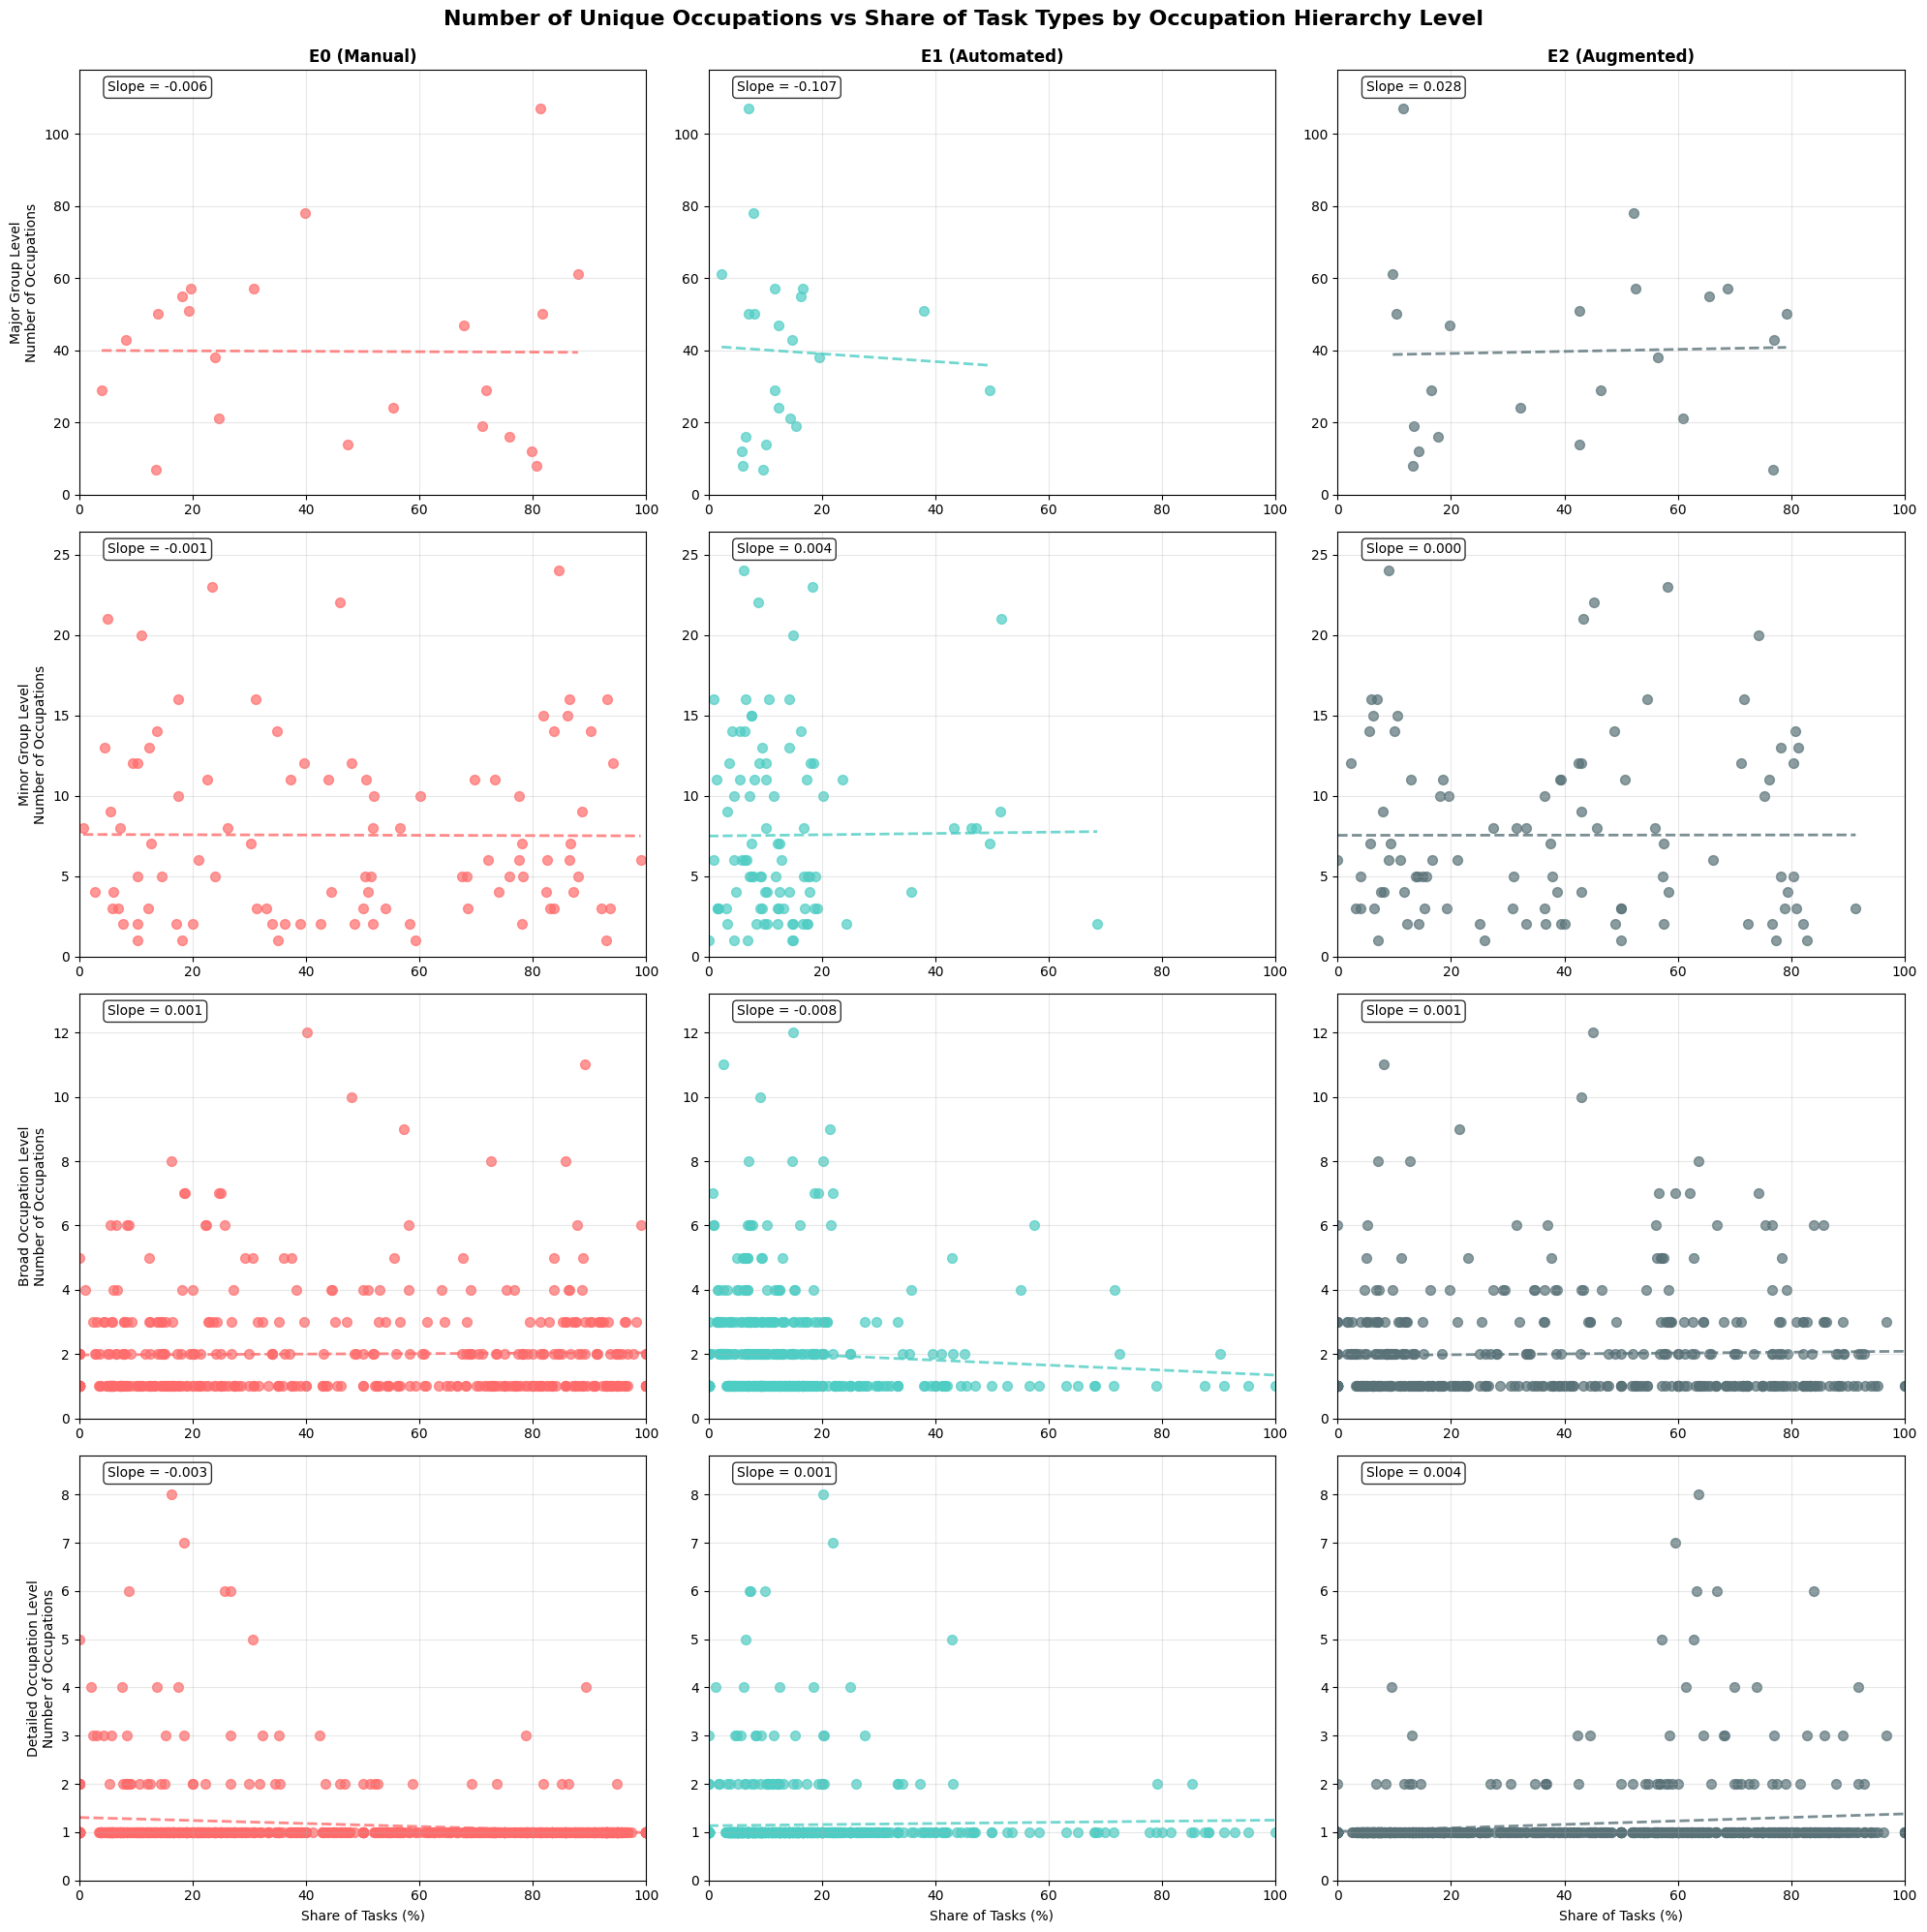

Second 5x3 scatter plot (occupations) created successfully!
Plot saved to: ../writeup/plots/occupations_vs_task_shares_scatter.png


In [239]:
# Create 5x3 figure: Number of unique occupations vs share of E0, E1, E2 tasks
# Prepare data for plotting with occupation counts (excluding Individual Occupation Level)
datasets_for_plot_occ = [
    (major_results_occ, 'Major Group Level'),
    (minor_results_occ, 'Minor Group Level'), 
    (broad_results_occ, 'Broad Occupation Level'),
    (detailed_results_occ, 'Detailed Occupation Level')
]

# Create figure with 4x3 subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
fig.suptitle('Number of Unique Occupations vs Share of Task Types by Occupation Hierarchy Level', 
             fontsize=16, fontweight='bold', y=0.995)

# Colors and labels (same as before)
colors = ['#FF6B6B', '#4ECDC4', "#597278"]  # Red for E0, Teal for E1, Blue for E2
task_types = [('E0_share_pct', 'E0 (Manual)'), ('E1_share_pct', 'E1 (Automated)'), ('E2_share_pct', 'E2 (Augmented)')]

for i, (data, level_name) in enumerate(datasets_for_plot_occ):
    for j, (share_col, task_label) in enumerate(task_types):
        ax = axes[i, j]
        
        # Get data for this plot
        x = data[share_col].values
        y = data['n_occupations'].values
        
        # Create scatter plot
        ax.scatter(x, y, color=colors[j], alpha=0.7, s=50)
        
        # Fit and plot regression line
        if len(x) > 1 and len(set(y)) > 1:  # Need at least 2 points and variation in y for regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            line_x = np.linspace(x.min(), x.max(), 100)
            line_y = slope * line_x + intercept
            ax.plot(line_x, line_y, color=colors[j], linestyle='--', linewidth=2, alpha=0.8)
            
            # Add slope value
            ax.text(0.05, 0.95, f'Slope = {slope:.3f}', 
                   transform=ax.transAxes, fontsize=10, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Customize plot
        if i == 0:  # Add title only to top row
            ax.set_title(f'{task_label}', fontsize=12, fontweight='bold')
        
        if i == 3:  # Add x-label only to bottom row
            ax.set_xlabel('Share of Tasks (%)')
        
        if j == 0:  # Add y-label only to leftmost column
            ax.set_ylabel(f'{level_name}\nNumber of Occupations')
        
        # Add grid
        ax.grid(True, alpha=0.3)
        
        # Set x-axis limits
        ax.set_xlim(0, 100)
        
        # Set y-axis to start from 0
        ax.set_ylim(0, max(y) * 1.1)

plt.tight_layout()
plt.savefig(f'{output_plot_path}/occupations_vs_task_shares_scatter.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("Second 5x3 scatter plot (occupations) created successfully!")
print(f"Plot saved to: {output_plot_path}/occupations_vs_task_shares_scatter.png")

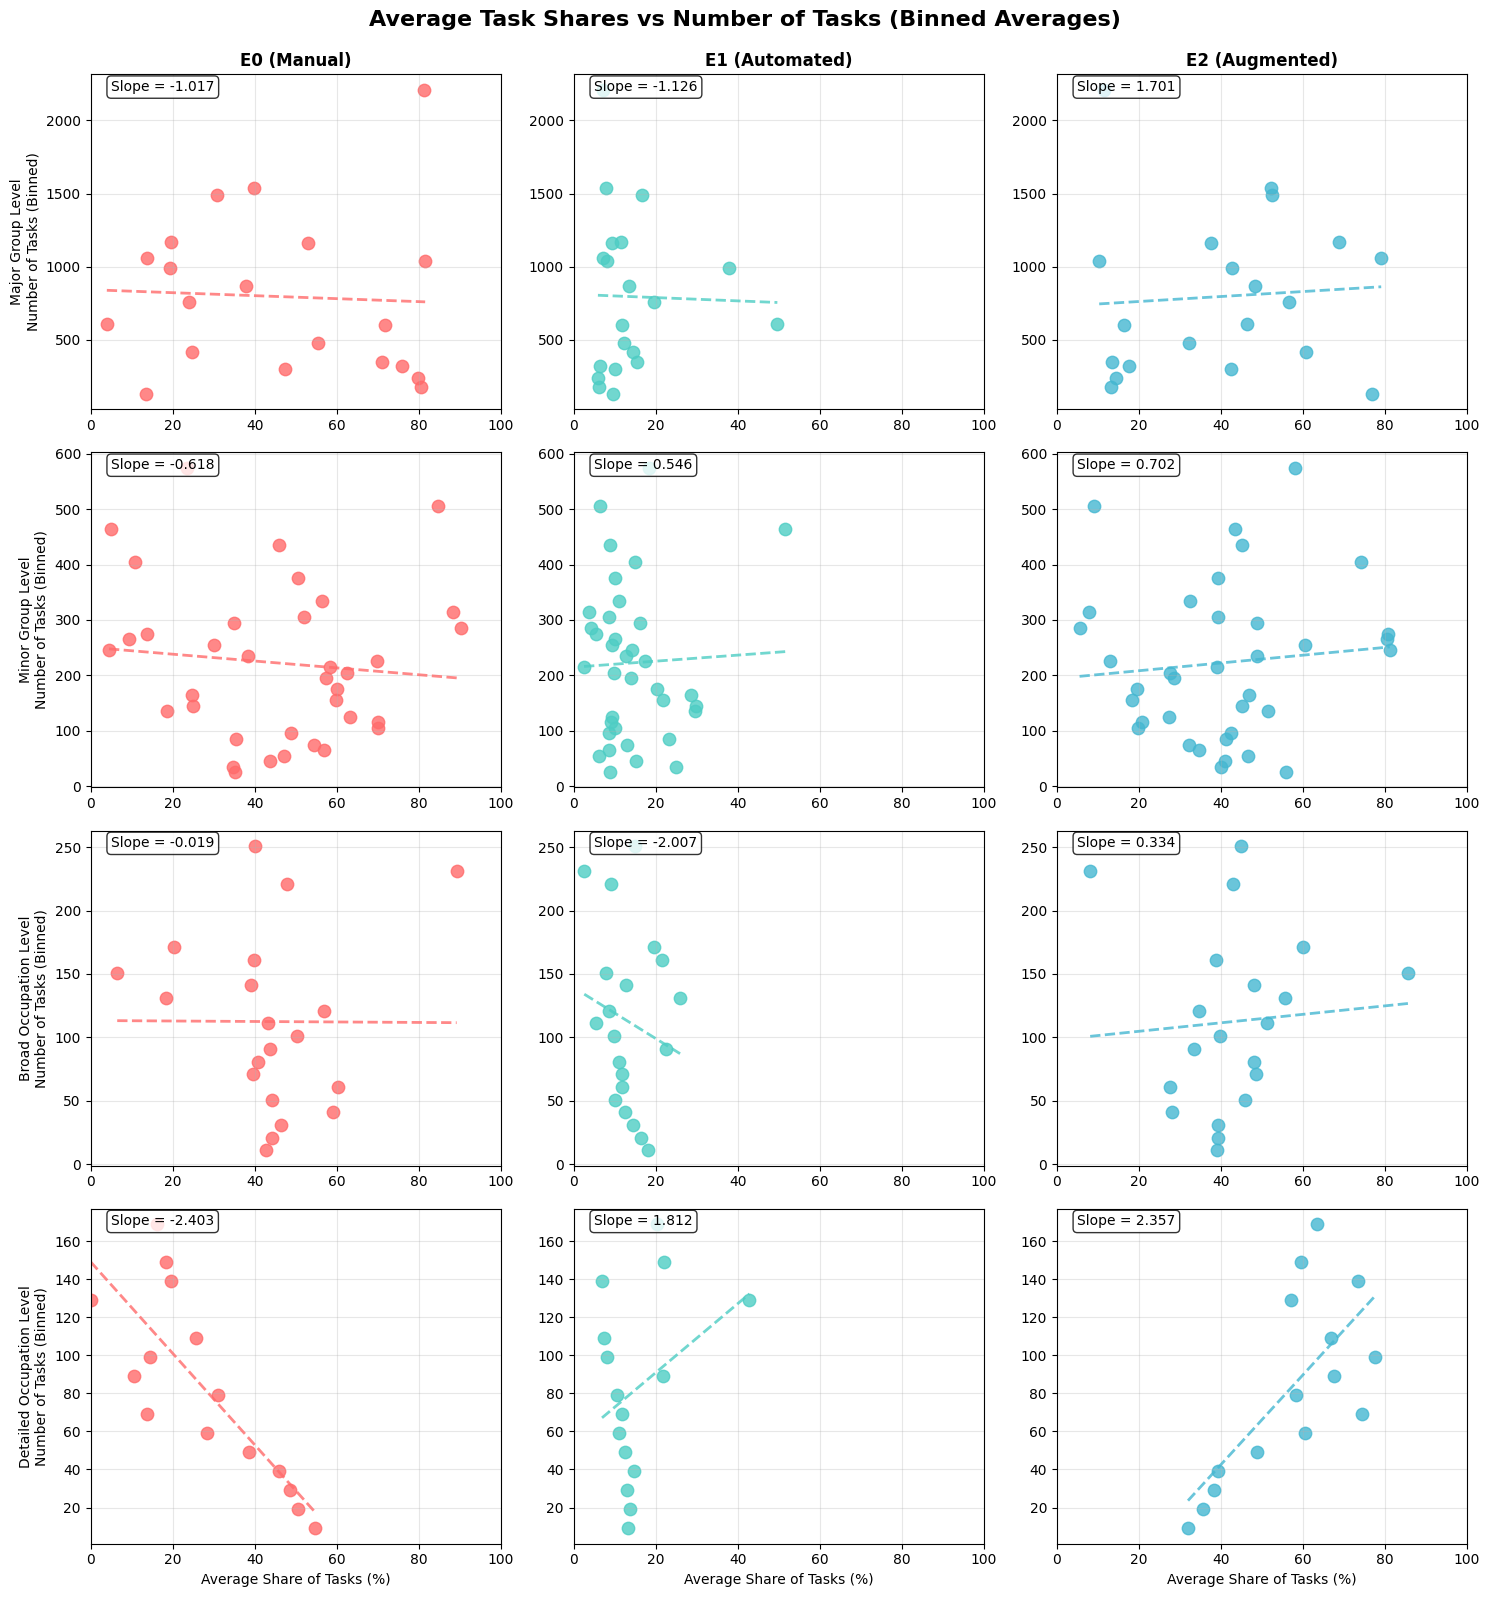

Binned tasks scatter plot created successfully!
Plot saved to: ../writeup/plots/binned_tasks_vs_task_shares_scatter.png


In [240]:
# Create 5x3 figure: Average task shares vs number of tasks (binned averages)
import pandas as pd

def create_binned_averages(data, y_col, share_cols, bin_size=5):
    """
    Create binned averages for plotting.
    Groups data by bins of y_col and calculates mean of share_cols for each bin.
    """
    # Create bins based on y_col values
    min_val = data[y_col].min()
    max_val = data[y_col].max()
    
    # Create bins with specified size
    bins = range(int(min_val), int(max_val) + bin_size, bin_size)
    data_copy = data.copy()
    data_copy[f'{y_col}_bin'] = pd.cut(data_copy[y_col], bins=bins, include_lowest=True)
    
    # Calculate averages for each bin - drop NaN bins
    binned_data = data_copy.groupby(f'{y_col}_bin', observed=True)[share_cols + [y_col]].mean().reset_index()
    
    # Get the midpoint of each bin for plotting
    binned_data[f'{y_col}_midpoint'] = binned_data[f'{y_col}_bin'].apply(lambda x: x.mid if pd.notna(x) else np.nan)
    
    # Remove rows with NaN midpoints
    binned_data = binned_data.dropna(subset=[f'{y_col}_midpoint'])
    
    return binned_data

# Create figure with 4x3 subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 16))
fig.suptitle('Average Task Shares vs Number of Tasks (Binned Averages)', 
             fontsize=16, fontweight='bold', y=0.995)

# Colors and labels
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Red for E0, Teal for E1, Blue for E2
task_types = [('E0_share_pct', 'E0 (Manual)'), ('E1_share_pct', 'E1 (Automated)'), ('E2_share_pct', 'E2 (Augmented)')]
share_cols = ['E0_share_pct', 'E1_share_pct', 'E2_share_pct']

for i, (data, level_name) in enumerate(datasets_for_plot):
    # Create binned data for this level
    binned_data = create_binned_averages(data, 'n_tasks', share_cols, bin_size=10)
    
    for j, (share_col, task_label) in enumerate(task_types):
        ax = axes[i, j]
        
        # Get data for this plot
        x = binned_data[share_col].values
        y = binned_data['n_tasks_midpoint'].values
        
        # Remove NaN values using pandas methods
        mask = ~(pd.isna(x) | pd.isna(y))
        x = x[mask]
        y = y[mask]
        
        if len(x) > 0:
            # Create scatter plot
            ax.scatter(x, y, color=colors[j], alpha=0.8, s=80)
            
            # Fit and plot regression line
            if len(x) > 1:
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                line_x = np.linspace(x.min(), x.max(), 100)
                line_y = slope * line_x + intercept
                ax.plot(line_x, line_y, color=colors[j], linestyle='--', linewidth=2, alpha=0.8)
                
                # Add slope value
                ax.text(0.05, 0.95, f'Slope = {slope:.3f}', 
                       transform=ax.transAxes, fontsize=10, 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Customize plot
        if i == 0:  # Add title only to top row
            ax.set_title(f'{task_label}', fontsize=12, fontweight='bold')
        
        if i == 3:  # Add x-label only to bottom row
            ax.set_xlabel('Average Share of Tasks (%)')
        
        if j == 0:  # Add y-label only to leftmost column
            ax.set_ylabel(f'{level_name}\nNumber of Tasks (Binned)')
        
        # Add grid
        ax.grid(True, alpha=0.3)
        
        # Set x-axis limits
        ax.set_xlim(0, 100)

plt.tight_layout()
plt.savefig(f'{output_plot_path}/binned_tasks_vs_task_shares_scatter.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("Binned tasks scatter plot created successfully!")
print(f"Plot saved to: {output_plot_path}/binned_tasks_vs_task_shares_scatter.png")

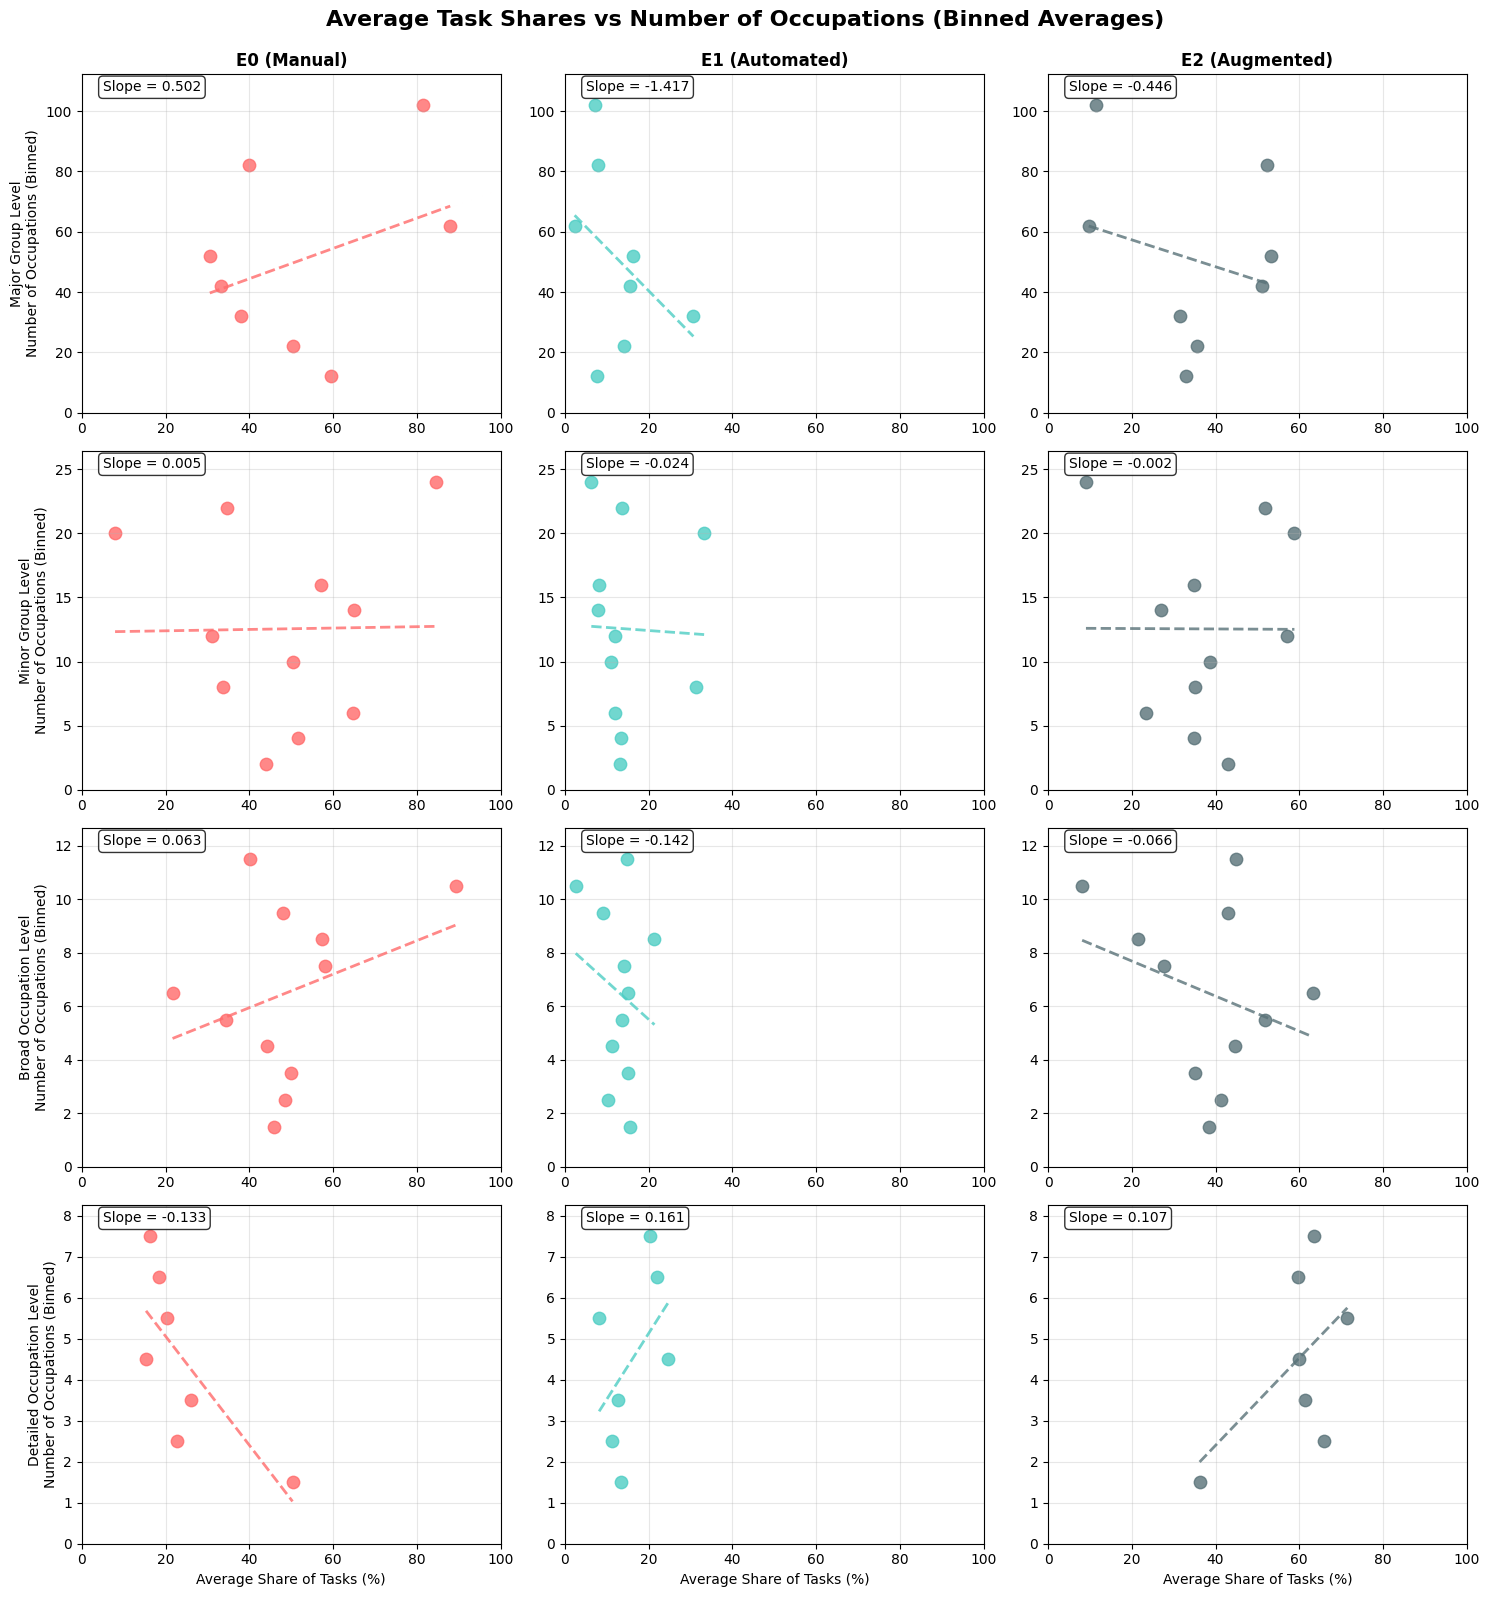

Binned occupations scatter plot created successfully!
Plot saved to: ../writeup/plots/binned_occupations_vs_task_shares_scatter.png


In [241]:
# Create 5x3 figure: Average task shares vs number of occupations (binned averages)
# Create figure with 4x3 subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 16))
fig.suptitle('Average Task Shares vs Number of Occupations (Binned Averages)', 
             fontsize=16, fontweight='bold', y=0.995)

# Colors and labels (same as before)
colors = ['#FF6B6B', '#4ECDC4', '#597278']  # Red for E0, Teal for E1, Blue for E2
task_types = [('E0_share_pct', 'E0 (Manual)'), ('E1_share_pct', 'E1 (Automated)'), ('E2_share_pct', 'E2 (Augmented)')]
share_cols = ['E0_share_pct', 'E1_share_pct', 'E2_share_pct']

for i, (data, level_name) in enumerate(datasets_for_plot_occ):
    # Determine appropriate bin size based on the range of occupations
    occ_range = data['n_occupations'].max() - data['n_occupations'].min()
    bin_size = max(1, int(occ_range / 10))  # Aim for about 10 bins
    
    # Create binned data for this level
    binned_data = create_binned_averages(data, 'n_occupations', share_cols, bin_size=bin_size)
    
    for j, (share_col, task_label) in enumerate(task_types):
        ax = axes[i, j]
        
        # Get data for this plot
        x = binned_data[share_col].values
        y = binned_data['n_occupations_midpoint'].values
        
        # Remove NaN values using pandas methods
        mask = ~(pd.isna(x) | pd.isna(y))
        x = x[mask]
        y = y[mask]
        
        if len(x) > 0:
            # Create scatter plot
            ax.scatter(x, y, color=colors[j], alpha=0.8, s=80)
            
            # Fit and plot regression line
            if len(x) > 1 and len(set(y)) > 1:
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                line_x = np.linspace(x.min(), x.max(), 100)
                line_y = slope * line_x + intercept
                ax.plot(line_x, line_y, color=colors[j], linestyle='--', linewidth=2, alpha=0.8)
                
                # Add slope value
                ax.text(0.05, 0.95, f'Slope = {slope:.3f}', 
                       transform=ax.transAxes, fontsize=10, 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Customize plot
        if i == 0:  # Add title only to top row
            ax.set_title(f'{task_label}', fontsize=12, fontweight='bold')
        
        if i == 3:  # Add x-label only to bottom row
            ax.set_xlabel('Average Share of Tasks (%)')
        
        if j == 0:  # Add y-label only to leftmost column
            ax.set_ylabel(f'{level_name}\nNumber of Occupations (Binned)')
        
        # Add grid
        ax.grid(True, alpha=0.3)
        
        # Set x-axis limits
        ax.set_xlim(0, 100)
        
        # Set y-axis to start from 0
        if len(y) > 0:
            ax.set_ylim(0, max(y) * 1.1)

plt.tight_layout()
plt.savefig(f'{output_plot_path}/binned_occupations_vs_task_shares_scatter.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("Binned occupations scatter plot created successfully!")
print(f"Plot saved to: {output_plot_path}/binned_occupations_vs_task_shares_scatter.png")